#Library and Data Loading

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split


In [8]:
train_df = pd.read_csv('Dataset/cleandata.csv')
print(train_df.shape)
print(train_df.describe())
print(train_df.info())

(1257, 25)
        Unnamed: 0          Age       Gender  self_employed  family_history  \
count  1257.000000  1257.000000  1257.000000    1257.000000     1257.000000   
mean    628.317422     0.319140     0.818616       0.114558        0.389817   
std     363.461683     0.162648     0.422915       0.318615        0.487903   
min       0.000000     0.000000     0.000000       0.000000        0.000000   
25%     314.000000     0.204545     1.000000       0.000000        0.000000   
50%     628.000000     0.295455     1.000000       0.000000        0.000000   
75%     942.000000     0.409091     1.000000       0.000000        1.000000   
max    1258.000000     1.000000     2.000000       1.000000        1.000000   

         treatment  work_interfere  no_employees  remote_work  tech_company  \
count  1257.000000     1257.000000   1257.000000  1257.000000   1257.000000   
mean      0.505171        2.287987      2.787589     0.297534      0.818616   
std       0.500172        1.595612      

In [11]:
# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

In [13]:

import tensorflow as tf
import argparse

In [14]:
print(tf.__version__)

2.9.2


In [15]:
batch_size = 100
train_steps = 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    return dataset.shuffle(1000).repeat().batch(batch_size)

def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

Define the feature columns

In [16]:
# Define Tensorflow feature columns
age = tf.feature_column.numeric_column("Age")
gender = tf.feature_column.numeric_column("Gender")
family_history = tf.feature_column.numeric_column("family_history")
benefits = tf.feature_column.numeric_column("benefits")
care_options = tf.feature_column.numeric_column("care_options")
anonymity = tf.feature_column.numeric_column("anonymity")
leave = tf.feature_column.numeric_column("leave")
work_interfere = tf.feature_column.numeric_column("work_interfere")
feature_columns = [age, gender, family_history, benefits, care_options, anonymity, leave, work_interfere]

Instantiate an Estimator

In [27]:
# Build a DNN with 2 hidden layers and 10 nodes in each hidden layer.
model = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                    hidden_units=[10, 10],
                                   optimizer='Adagrad',
                                   
                                   activation_fn=tf.nn.relu,
                                    )

In [32]:
model = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[1024, 512, 256],
    optimizer=lambda: tf.keras.optimizers.Adam(
        learning_rate=tf.compat.v1.train.exponential_decay(
            learning_rate=0.1,
            global_step=tf.compat.v1.train.get_global_step(),
            decay_steps=10000,
            decay_rate=0.96)))

Train the model

In [33]:
model.train(input_fn=lambda:train_input_fn(X_train, y_train, batch_size), steps=train_steps,verbose=True)

Evaluate the model

In [34]:
# Evaluate the model.
eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(X_test, y_test, batch_size))

print('\nTest set accuracy: {accuracy:0.2f}\n'.format(**eval_result))

#Data for final graph
accuracy = eval_result['accuracy'] * 100
methodDict['Neural Network'] = accuracy


Test set accuracy: 0.81



Making predictions (inferring) from the trained model

In [35]:
predictions = list(model.predict(input_fn=lambda:eval_input_fn(X_train, y_train, batch_size=batch_size)))

In [36]:
# Generate predictions from the model
template = ('\nIndex: "{}", Prediction is "{}" ({:.1f}%), expected "{}"')

# Dictionary for predictions
col1 = []
col2 = []
col3 = []


for idx, input, p in zip(X_train.index, y_train, predictions):
    v  = p["class_ids"][0] 
    class_id = p['class_ids'][0]
    probability = p['probabilities'][class_id] # Probability
    
    # Adding to dataframe
    col1.append(idx) # Index
    col2.append(v) # Prediction
    col3.append(input) # Expecter
    
   
    #print(template.format(idx, v, 100 * probability, input))


results = pd.DataFrame({'index':col1, 'prediction':col2, 'expected':col3})
results.head()

,index,prediction,expected
0,929,0,0
1,901,1,1
2,579,1,1
3,367,1,1
4,615,1,1


#Success method plot

In [37]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = s.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([70.0, 90.0])
    plt.xlabel('Method')
    plt.ylabel('Percentage')
    plt.title('Success of methods')
     
    plt.show()

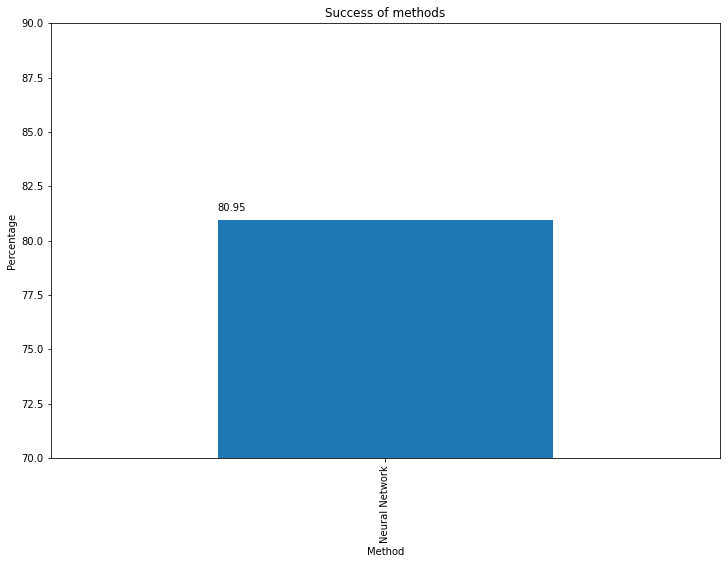

In [38]:
plotSuccess()